[INFO] PROJECT_ROOT = /Users/franco/Desktop/CoSyBio/Multi-Dim/TM-Landscape
[INFO] Using device: cpu
[INFO] Loading ProtT5...
[INFO] Loading TM-Vec...


Lightning automatically upgraded your loaded checkpoint from v1.8.0rc0 to v2.5.6. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../models/TM-vec/tm_vec_cath_model_large.ckpt`


[INFO] Computing deterministic embeddings (dropout=0)


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


[DETERMINISM] max difference across 10 runs = 0.000e+00

[INFO] Sampling dropout=0.0


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


  mean=0.0000, std=0.0000, min=0.0000, max=0.0000

[INFO] Sampling dropout=0.05


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


  mean=5.2775, std=0.3923, min=4.6510, max=6.2004

[INFO] Sampling dropout=0.1


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


  mean=7.6134, std=0.5714, min=6.8483, max=8.8724

[INFO] Sampling dropout=0.2


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


  mean=10.9053, std=0.6655, min=10.2117, max=12.0982

[INFO] Sampling dropout=0.3


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


  mean=13.8929, std=0.5801, min=12.9580, max=15.1291

[INFO] Sampling dropout=0.4


100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


  mean=17.1732, std=0.6757, min=16.0219, max=18.2659

[INFO] Sampling dropout=0.5


100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


  mean=19.7088, std=0.5351, min=18.8487, max=20.3950
[INFO] Loading TM-Vec CATH (large) embeddings...
[INFO] Subsampled 2501/500238 embeddings (0.5%).
[INFO] Loaded embeddings → shape (2501, 512)

[INFO] Z_ref: (2501, 512)
[INFO] Running t-SNE...


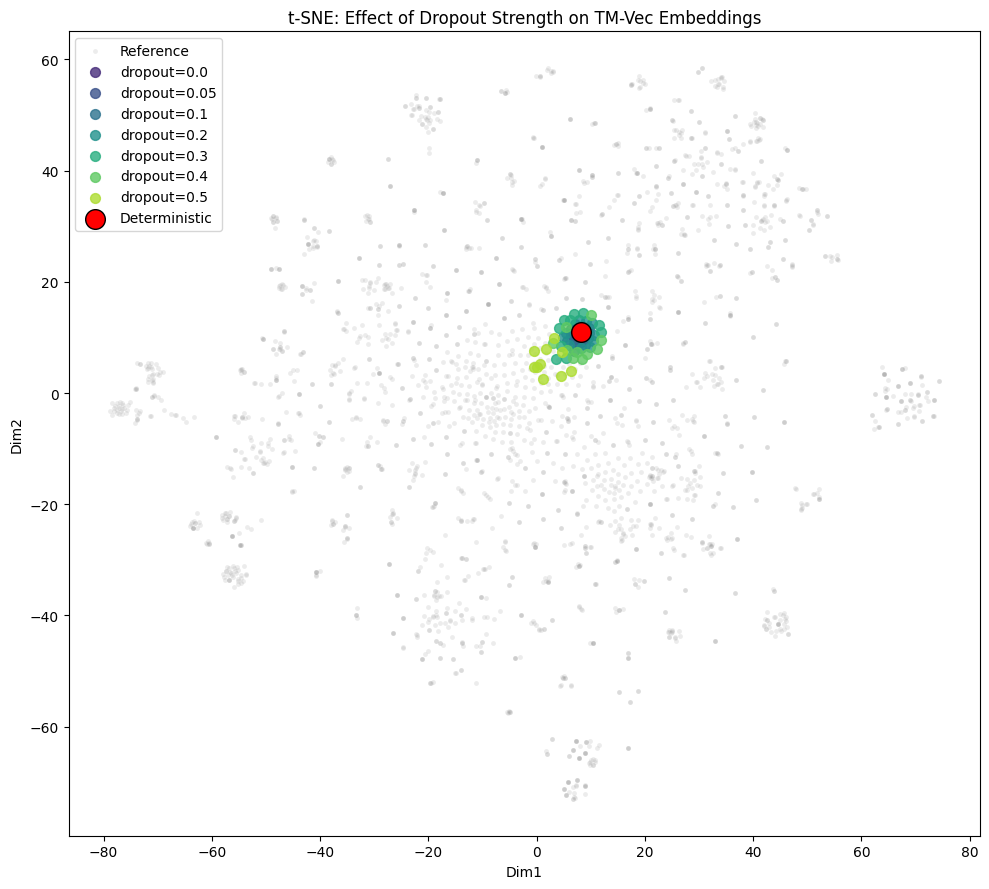

/var/folders/v4/0kfg9gxn3zggdx1mvc9q79wr0000gp/T/ipykernel_23104/3966058030.py:188: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(distance_stats[p], label=f"dropout={p}", linewidth=2, color=color)


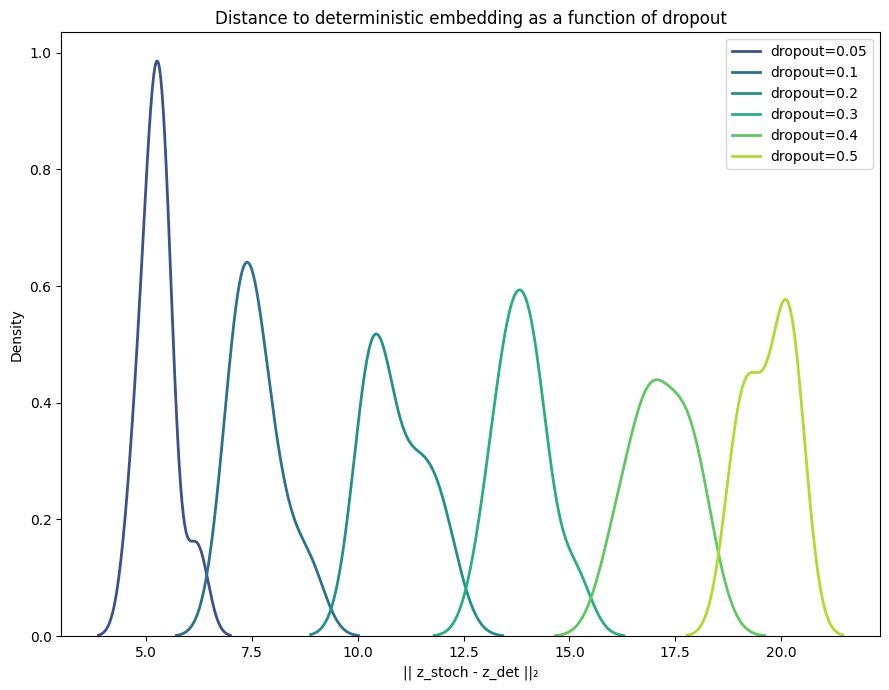

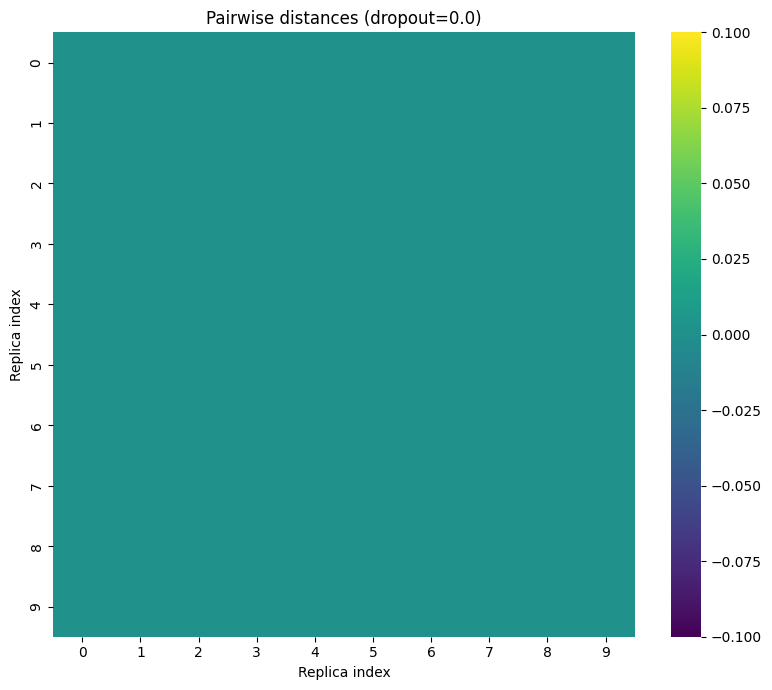

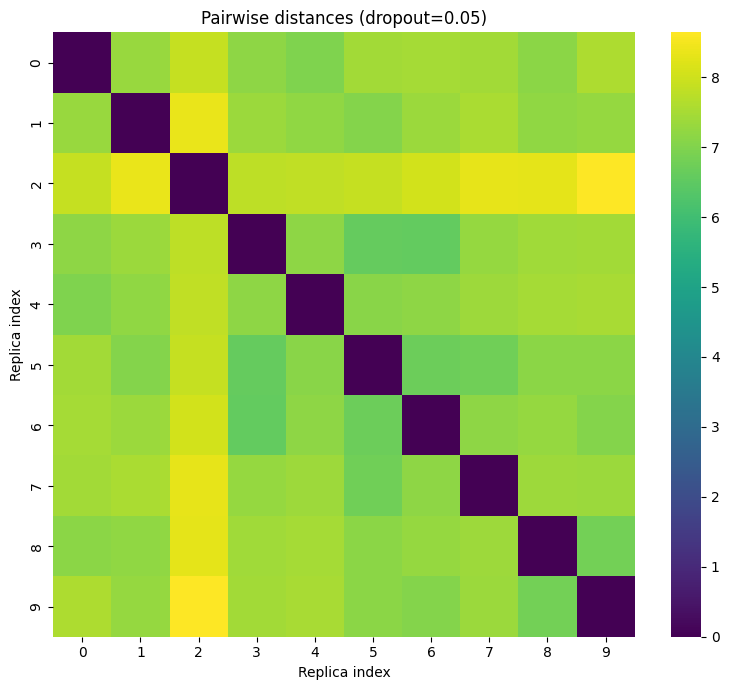

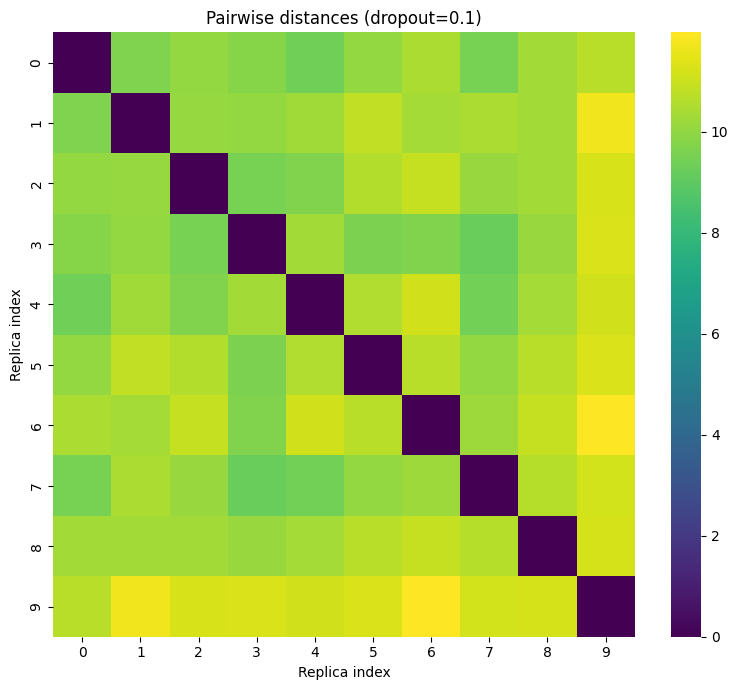

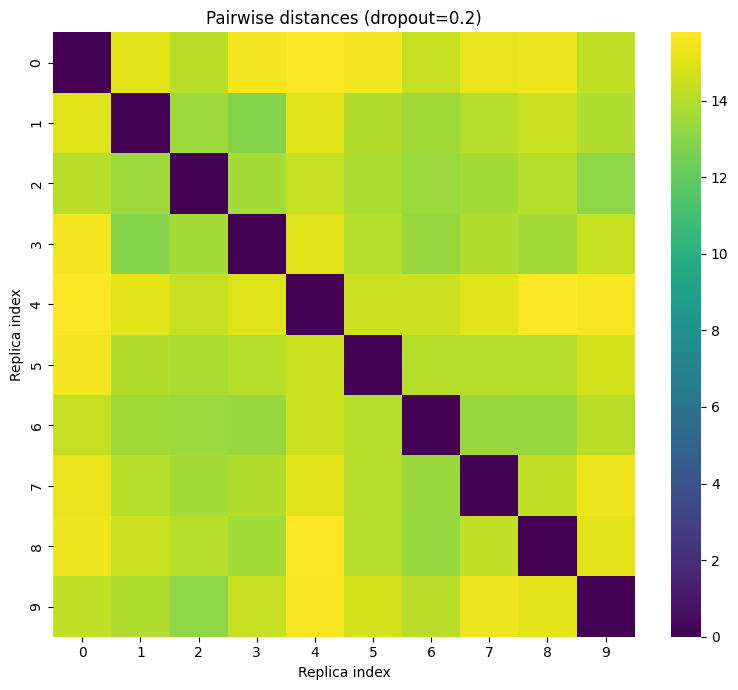

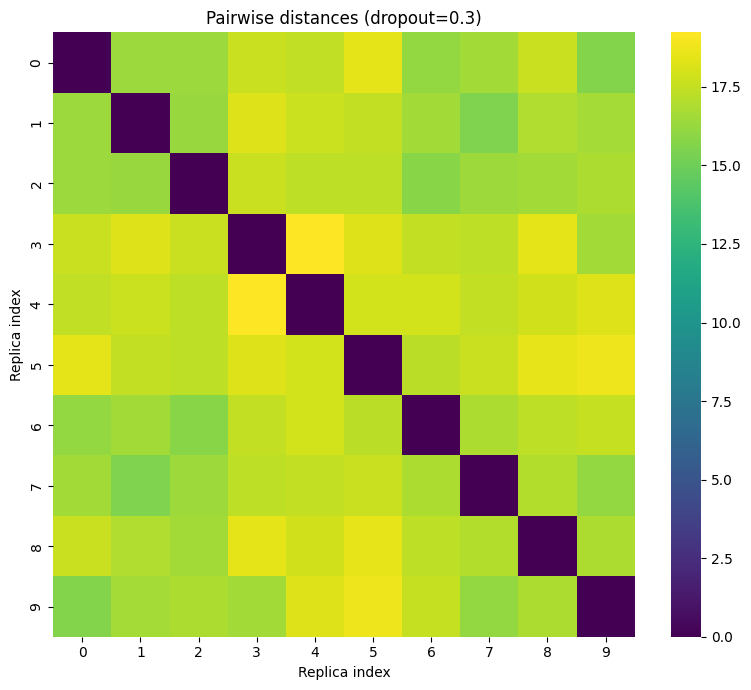

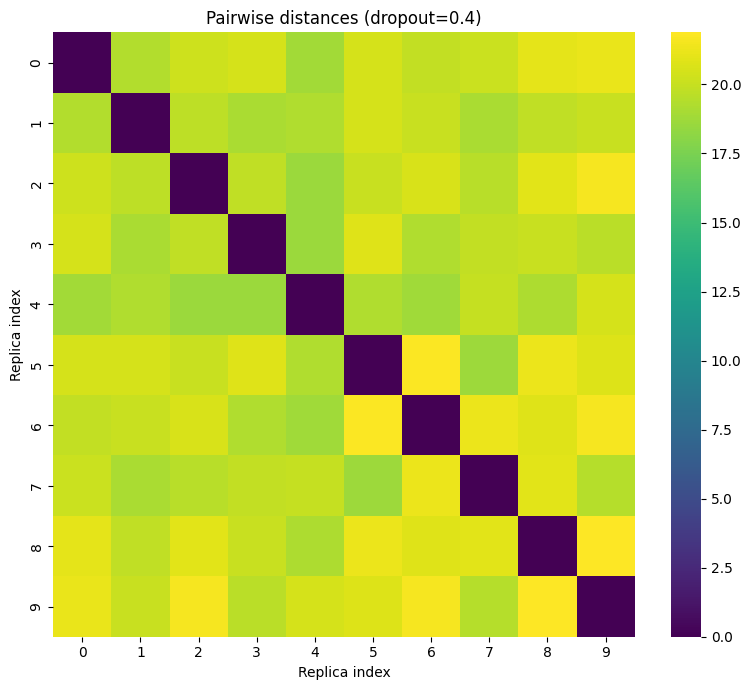

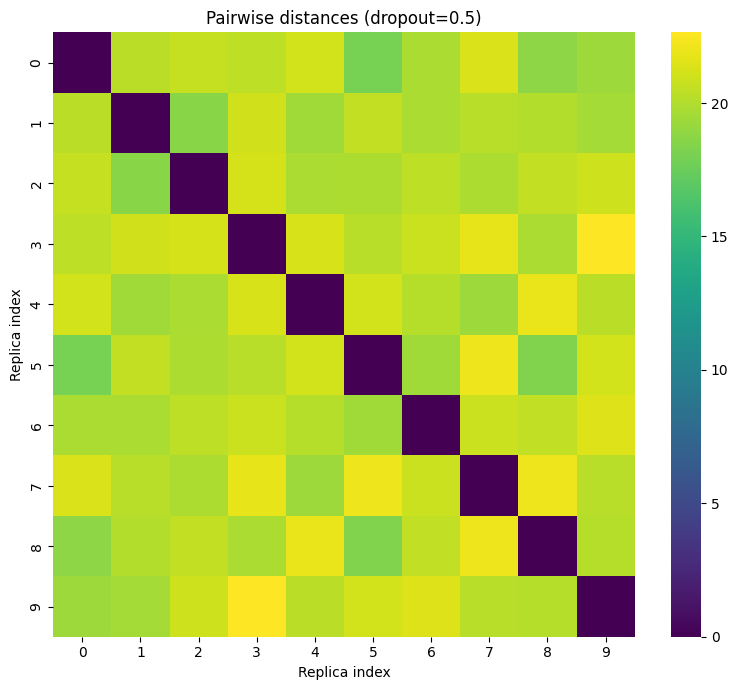

In [ ]:
# ======================================================================
# TM-Vec: dropout-controlled stochastic embeddings + t-SNE
# ======================================================================

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from transformers import T5Tokenizer, T5EncoderModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# TM-Vec
from tm_vec.embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec.tm_vec_utils import encode

# ----------------------------------------------------------------------
# Discover project root
# ----------------------------------------------------------------------
def find_project_root(start: Path):
    p = start.resolve()
    for parent in [p] + list(p.parents):
        if (parent / "scripts").exists():
            return parent
    raise RuntimeError("No 'scripts/' folder found.")

PROJECT_ROOT = find_project_root(Path.cwd())
sys.path.append(str(PROJECT_ROOT))

from scripts.eval.run_tmvec_energy import get_tmvec_config
from scripts.utils.load_tmvec_embeddings import load_tmvec_embeddings

print(f"[INFO] PROJECT_ROOT = {PROJECT_ROOT}")

# ----------------------------------------------------------------------
# Load models
# ----------------------------------------------------------------------
source, size = "cath", "large"
cfg = get_tmvec_config(source, size)

prot_t5_dir = cfg["prot_t5_dir"]
tm_vec_ckpt = cfg["tm_vec_ckpt"]
tm_vec_json = cfg["tm_vec_json"]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

print("[INFO] Loading ProtT5...")
tokenizer = T5Tokenizer.from_pretrained(str(prot_t5_dir), do_lower_case=False)
prot_model = T5EncoderModel.from_pretrained(str(prot_t5_dir)).to(device).eval()

print("[INFO] Loading TM-Vec...")
tm_config = trans_basic_block_Config.from_json(str(tm_vec_json))
tm_model = trans_basic_block.load_from_checkpoint(str(tm_vec_ckpt), config=tm_config).to(device).eval()

# ----------------------------------------------------------------------
# Utility: override dropout probability
# ----------------------------------------------------------------------
def set_dropout(model, p: float):
    """
    Override *all* dropout probabilities inside TM-Vec.

    TM-Vec has two kinds of dropout:
    1) nn.Dropout modules  -> have attribute .p
    2) attention dropout   -> stored as a float in layer.self_attn.dropout
    """

    # Final dropout
    model.dropout.p = p

    for layer in model.encoder.layers:
        # Feedforward + residual dropout modules
        layer.dropout.p  = p
        layer.dropout1.p = p
        layer.dropout2.p = p

        # Attention dropout (float)
        layer.self_attn.dropout = p

# ----------------------------------------------------------------------
# Encode wrapper with optional dropout
# ----------------------------------------------------------------------
def encode_with_dropout(sequences, dropout_p: float):
    prot_model.eval()     # ProtT5 always deterministic
    set_dropout(tm_model, dropout_p)
    tm_model.train() if dropout_p > 0 else tm_model.eval()

    with torch.no_grad():
        Z = encode(sequences, tm_model, prot_model, tokenizer, device)
    return np.array(Z)

# ======================================================================
# 1. Deterministic embedding (baseline)
# ======================================================================

seq = "MLSDADFKAAVGMTRSAFANLPLWKQQNLKKEKGLF"

print("[INFO] Computing deterministic embeddings (dropout=0)")
Z_det_repeats = encode_with_dropout([seq] * 10, dropout_p=0.0)
z_det = Z_det_repeats[0:1, :]

max_diff = np.abs(Z_det_repeats - Z_det_repeats[0]).max()
print(f"[DETERMINISM] max difference across 10 runs = {max_diff:.3e}")

# ======================================================================
# 2. Generate stochastic embeddings for increasing dropout levels
# ======================================================================

dropout_levels = [0.0, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
n_reps = 10

all_embeddings = {}
distance_stats = {}

for p in dropout_levels:
    print(f"\n[INFO] Sampling dropout={p}")
    Z = encode_with_dropout([seq] * n_reps, dropout_p=p)

    # Distances to deterministic baseline
    d = np.linalg.norm(Z - z_det, axis=1)
    all_embeddings[p] = Z
    distance_stats[p] = d

    print(f"  mean={d.mean():.4f}, std={d.std():.4f}, min={d.min():.4f}, max={d.max():.4f}")

# ======================================================================
# 3. Load reference manifold
# ======================================================================

Z_ref, metadata = load_tmvec_embeddings("cath", "large", frac=0.005)
n_ref = Z_ref.shape[0]
print(f"[INFO] Z_ref: {Z_ref.shape}")

# ======================================================================
# 4. Build t-SNE dataset
# ======================================================================

Z_plot = [Z_ref, z_det] + [all_embeddings[p] for p in dropout_levels]
Z_all = np.vstack(Z_plot)

print("[INFO] Running t-SNE...")
tsne = TSNE(n_components=2, learning_rate="auto", init="random", perplexity=30)
Z_tsne = tsne.fit_transform(Z_all)

# Build dataframe
labels = (
    ["Reference"] * len(Z_ref)
    + ["Deterministic"]
    + sum([[f"dropout={p}"] * n_reps for p in dropout_levels], [])
)

tsne_df = pd.DataFrame(Z_tsne, columns=["Dim1", "Dim2"])
tsne_df["Type"] = labels

# ======================================================================
# 5. t-SNE plot
# ======================================================================

plt.figure(figsize=(10, 9))
sns.scatterplot(
    data=tsne_df[tsne_df["Type"] == "Reference"],
    x="Dim1", y="Dim2",
    s=12, alpha=0.15, color="gray", label="Reference"
)

palette = sns.color_palette("viridis", len(dropout_levels))

for color, p in zip(palette, dropout_levels):
    dfp = tsne_df[tsne_df["Type"] == f"dropout={p}"]
    plt.scatter(dfp["Dim1"], dfp["Dim2"], s=50, alpha=0.8, color=color, label=f"dropout={p}")

dfd = tsne_df[tsne_df["Type"] == "Deterministic"]
plt.scatter(dfd["Dim1"], dfd["Dim2"], s=200, color="red", edgecolor="black", label="Deterministic", zorder=10)

plt.title("t-SNE: Effect of Dropout Strength on TM-Vec Embeddings")
plt.legend()
plt.tight_layout()
plt.show()

# ======================================================================
# 6. Histograms of distances to deterministic embedding
# ======================================================================

plt.figure(figsize=(9,7))
for p, color in zip(dropout_levels, palette):
    sns.kdeplot(distance_stats[p], label=f"dropout={p}", linewidth=2, color=color)
plt.xlabel("|| z_stoch - z_det ||₂")
plt.title("Distance to deterministic embedding as a function of dropout")
plt.legend()
plt.tight_layout()
plt.show()

# ======================================================================
# 7. Pairwise distance heatmaps for each dropout level
# ======================================================================

for p in dropout_levels:
    Z = all_embeddings[p]
    D = np.linalg.norm(Z[:,None,:] - Z[None,:,:], axis=2)

    plt.figure(figsize=(8,7))
    sns.heatmap(D, cmap="viridis")
    plt.title(f"Pairwise distances (dropout={p})")
    plt.xlabel("Replica index")
    plt.ylabel("Replica index")
    plt.tight_layout()
    plt.show()

